<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model performance analysis





Datasets:
*   COCO17
*   PWMFD

Metrics:
*   mAP
*   mAR
*   fps
*   GFLOPs
*   Memory

Models:
<br>

| Model | Backbone | Image Size | Parameters| GFLOPs | Weight Size
| --- | --- | --- | --- | --- | ---
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 | 13.4MB
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 | 136MB
| RetinaNet | ResNet-50 FPN | 800x800 | 34M | 303.5 | 130MB
| Faster R-CNN |  MobileNetV3-Large FPN | 800x800 | 19.4M | 9 | 74.3MB
| Faster R-CNN |  MobileNetV3-Large FPN  | 320x320 | 19.4M | 1.4 | 74.2MB 
| Faster R-CNN |  ResNet-50 FPN | 800x800 | 41.8M | 240.4 | 160MB
| Mask R-CNN |  ResNet-50 FPN | 800x800 | 44.4M | 259.9 | 170MB
| YOLOv5n |  Custom CSPDarknet | 640x640 | 1.9M | 4.5 | 3.8MB
| YOLOv5s |  Custom CSPDarknet | 640x640 | 7.2M | 16.5 | 14MB
| YOLOv5m |  Custom CSPDarknet | 640x640 | 21.2M | 49 | 40.5MB
| YOLOv5l |  Custom CSPDarknet |640x640 | 47M | 115.5 | 89.2MB
| YOLOv4 |  CSPDarknet53 | 608x608 | 64.4M | 128.9 | 258MB
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 | 17MB
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 | 119MB
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 | 121MB

### Initialization

In [36]:
# Parameters

dataset_name = 'COCO17'  # Dataset to show results for: 'PWMFD' or 'COCO17'
gpus =  ['gtx960'] # Selected gpus to show results for: ['gtx960'], ['k80'] or ['gtx960','k80']
subfolder = None  # Selected subfolder (only for PWMFD dataset), if None, subfolder won't be used, else use one of these: 'model', 'img_size', 'optimizer', 'transfer_learning', 'augmentations', 'se_block', 'te_block'


# Directories

root_results_dir = '/content/results/'  # Get from GDrive with: '/content/drive/MyDrive/object-detection-results/

import os
root_dir = os.getcwd()  # Root dir of project
results_dir = os.path.join(root_results_dir,dataset_name,(subfolder if subfolder else ""))

### Get requirements
*Note: Restart runtime after installation*

In [2]:
# Clone asset files
!cd {root_dir}
!git clone https://github.com/joangog/object-detection-assets
!mv -n {os.path.join(root_dir,'object-detection-assets','results')} ./
!rm -rf {os.path.join(root_dir,'object-detection-assets')}

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 328 (delta 23), reused 25 (delta 22), pack-reused 300
Receiving objects: 100% (328/328), 47.22 MiB | 24.73 MiB/s, done.
Resolving deltas: 100% (153/153), done.


In [3]:
# Install packages
!pip install matplotlib==3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.3 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


### Import packages

In [30]:
# Comment google.colab package if using local runtime
from google.colab import drive

import os

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 1000)  # Maximum display width for table in pandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import textwrap as tw

# Function for converting mAP to percentage
def to_percent(mAP):
  if (type(mAP) == list or type(mAP) == np.ndarray):
    return [int(mAP_val*100) for mAP_val in mAP] 
  else:
    print(1)
    return int(mAP*100)

### (Optional) Connect to GDrive for storage access

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Gather results from files

In [37]:
results_files = os.listdir(results_dir)
results_files = [file for file in results_files if ('.csv' in file) and (dataset_name in file) and (any([gpu in file for gpu in gpus]))]

print('Files found:')

# Gather results
results = pd.DataFrame(dtype=str, columns=['model', 'model_img_size', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score', 'gpu'])
for file in results_files:
  print(f'\t{file}')
  file_path = os.path.join(results_dir,file)
  results_temp = pd.read_csv(file_path)
  for gpu in gpus:
    if gpu in file:
      results_temp['gpu'] = gpu
  results = results.append(results_temp)
results = results.reset_index().iloc[:,1:-1]  # Drop uneeded columns
results = results.sort_values(by=['model','model_img_size'],ascending=[True,False])
# Put YOLOv5n last in order
results_yolov5n = results[(results['model']=='YOLOv5n') | (results['model'].str.contains('yolov5n'))]
results = results[(results['model']!='YOLOv5n') & (~results['model'].str.contains('yolov5n'))]
results = results.append(results_yolov5n).reset_index().drop(columns=['index'])

Files found:
	COCO17_gtx960_yolov4_608_metrics.csv
	COCO17_gtx960_ssd300_vgg16_metrics.csv
	COCO17_gtx960_ssdlite320_mobilenet_v3_large_metrics.csv
	COCO17_gtx960_yolov3_tiny_640_metrics.csv
	COCO17_gtx960_yolov3_640_metrics.csv
	COCO17_gtx960_yolov5n_640_metrics.csv
	COCO17_gtx960_maskrcnn_resnet50_fpn_metrics.csv
	COCO17_gtx960_yolov5m_640_metrics.csv
	COCO17_gtx960_fasterrcnn_mobilenet_v3_large_fpn_metrics.csv
	COCO17_gtx960_fasterrcnn_resnet50_fpn_metrics.csv
	COCO17_gtx960_fasterrcnn_mobilenet_v3_large_320_fpn_metrics.csv
	COCO17_gtx960_yolov5l_640_metrics.csv
	COCO17_gtx960_yolov5s_640_metrics.csv
	COCO17_gtx960_retinanet_resnet50_fpn_metrics.csv
	COCO17_gtx960_yolov3_spp_640_metrics.csv


### Set plotting variables

In [38]:
# Plot variables

matplotlib.rcParams['figure.dpi'] = 200

if dataset_name == 'COCO17':
  markers = ['>','o','v','^','s','p',
             'P','*','<','h','X','D','H','d','8']
  colors = ['tab:blue', 'tab:blue','tab:blue','tab:orange', 'tab:brown', 'tab:green','tab:green',
            'tab:red','tab:red','tab:red', 'tab:cyan', 'tab:purple', 'tab:purple','tab:purple','tab:purple']
  models = results.model.unique()
  models_short = ['FR-CNN MbNv3-L 320', 'FR-CNN MbNv3-L', 'FR-CNN RsN50', 'MR-CNN  RsN50', 'RtN RsN50', 'SSD300 VGG16', 'SSDlite320 MbNv3-L',
                  'YOLOv3','YOLOv3-spp','YOLOv3-tiny', 'YOLOv4', 'YOLOv5l', 'YOLOv5m', 'YOLOv5s', 'YOLOv5n']
elif dataset_name == 'PWMFD':
  markers = ['>','o','v','^','s','p',
            'P','*','<','h','X','D','H','d','8']
  colors = ['tab:blue', 'tab:blue','tab:blue','tab:orange', 'tab:brown', 'tab:green','tab:green',
            'tab:red','tab:red','tab:red', 'tab:cyan', 'tab:purple', 'tab:purple','tab:purple','tab:purple']
  models = results.model.unique()
  models_short = models
  if subfolder == 'model':
    markers = ['o','s','^']
    colors = ['tab:blue', 'tab:orange','tab:red']
    models = results.model.unique()
    models_short = ['YOLOv5m', 'YOLOv5s', 'YOLOv5n']
  elif subfolder == 'img_size':
    markers = ['o','h','s','^']
    colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red']
    models = results.model.unique()
    models_short = ['YOLOv5s-320', 'YOLOv5s-416', 'YOLOv5s-512', 'YOLOv5s-608']
  elif subfolder == 'optimizer':
    markers = ['o','h','s','^']
    colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red']
    models = results.model.unique()
    models_short = ['Adam', 'SGDM']
  elif subfolder == 'transfer_learning':
    markers = ['o','h','s','^']
    colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red']
    models = results.model.unique()
    models_short = ['TL + Freeze Backbone', 'TL + Freeze All', 'Νο TL', 'TL + No Freeze']
  elif subfolder == 'augmentations':
    markers = ['o','h','s','^']
    colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red']
    models = results.model.unique()
    models_short = ['Basic + Mosaic', 'Basic + Mosaic + Mixup', 'Basic']
  elif subfolder == 'te_block':
    markers = ['o','h','s','^']
    colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red']
    models = results.model.unique()
    models_short = ['No TE', 'TE (Backbone)', 'TE (Heads)', 'TE (Backbone + Heads)']
  elif subfolder == 'se_block':
    markers = ['o','h','s','^']
    colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red']
    models = results.model.unique()
    models_short = ['No SE', 'SE + FL', 'SE ', 'SE + Mixup + FL', 'SE + Mixup']
 

### Gather metrics


In [39]:
# Get following model metrics

# mAP per IoU
mAP = results[  # COCO Challenge metric
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_50 = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_75 = results[  # PASCAL VOC Challenge metric
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.75') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values

# mAP per object size
mAP_small = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'small') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_medium = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'medium') &
              (results['max_dets'] == 100)
              ]['score'].values
mAP_large = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_precision') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'large') &
              (results['max_dets'] == 100)
              ]['score'].values
          
# mAR per maximum detections
mAR = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR_1 = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 1)
              ]['score'].values
mAR_10 = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'all') &
              (results['max_dets'] == 10)
              ]['score'].values

#mAR per object size
mAR_small = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'small') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR_medium = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'medium') &
              (results['max_dets'] == 100)
              ]['score'].values
mAR_large = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == 'avg_recall') & 
              (results['iou'] == '0.50:0.95') &
              (results['area'] == 'large') &
              (results['max_dets'] == 100)
              ]['score'].values


### Show performance table

In [40]:
grouped_results = results.groupby(by=['model','model_img_size'])

perf_table = grouped_results.first().iloc[:,:4].reset_index()
# Put YOLOv5n last in order
perf_table_yolov5n = perf_table[(perf_table['model']=='YOLOv5n') | (perf_table['model'].str.contains('yolov5n'))]
perf_table = perf_table[(perf_table['model']!='YOLOv5n') & (~perf_table['model'].str.contains('yolov5n'))]
perf_table = perf_table.append(perf_table_yolov5n).reset_index().drop(columns=['index'])

model_img_size = perf_table['model_img_size'].values
model_params = perf_table['model_params'].values
model_gflops = perf_table['model_gflops'].values
fps = perf_table['fps'].values
max_mem = perf_table['max_mem'].values

perf_table['map'] = mAP
perf_table['map_50'] = mAP_50
perf_table['map_75'] = mAP_75
perf_table['mar'] = mAR
  
perf_table = perf_table.round(2)  # Round to two decimals

perf_table

,model,model_img_size,model_params,model_gflops,fps,max_mem,map,map_50,map_75,mar
0,Faster R-CNN MobileNetV3-Large 320 FPN,320,19.4,1.4,41.96,195.67,0.23,0.38,0.23,0.29
1,Faster R-CNN MobileNetV3-Large FPN,800,19.4,9.0,12.24,304.76,0.33,0.53,0.34,0.44
2,Faster R-CNN ResNet-50 FPN,800,41.8,240.4,3.55,593.81,0.37,0.59,0.40,0.51
3,Mask R-CNN ResNet-50 FPN,800,44.4,259.9,3.29,603.65,0.38,0.59,0.41,0.52
4,RetinaNet ResNet-50 FPN,800,34.0,303.5,3.20,428.73,0.36,0.56,0.38,0.54
5,SSD300 VGG16,300,35.6,69.8,14.84,209.81,0.25,0.42,0.26,0.36
6,SSDlite320 MobileNetV3-Large,320,3.4,1.2,26.10,33.27,0.21,0.34,0.22,0.33
7,YOLOv3,640,61.9,156.3,11.09,300.77,0.37,0.52,0.40,0.44
8,YOLOv3-spp,640,63.0,157.1,11.92,306.23,0.38,0.54,0.41,0.44
9,YOLOv3-tiny,640,8.8,13.3,69.37,91.42,0.12,0.22,0.12,0.15


### Plot fps per GPU (Only for more than one gpu selected)

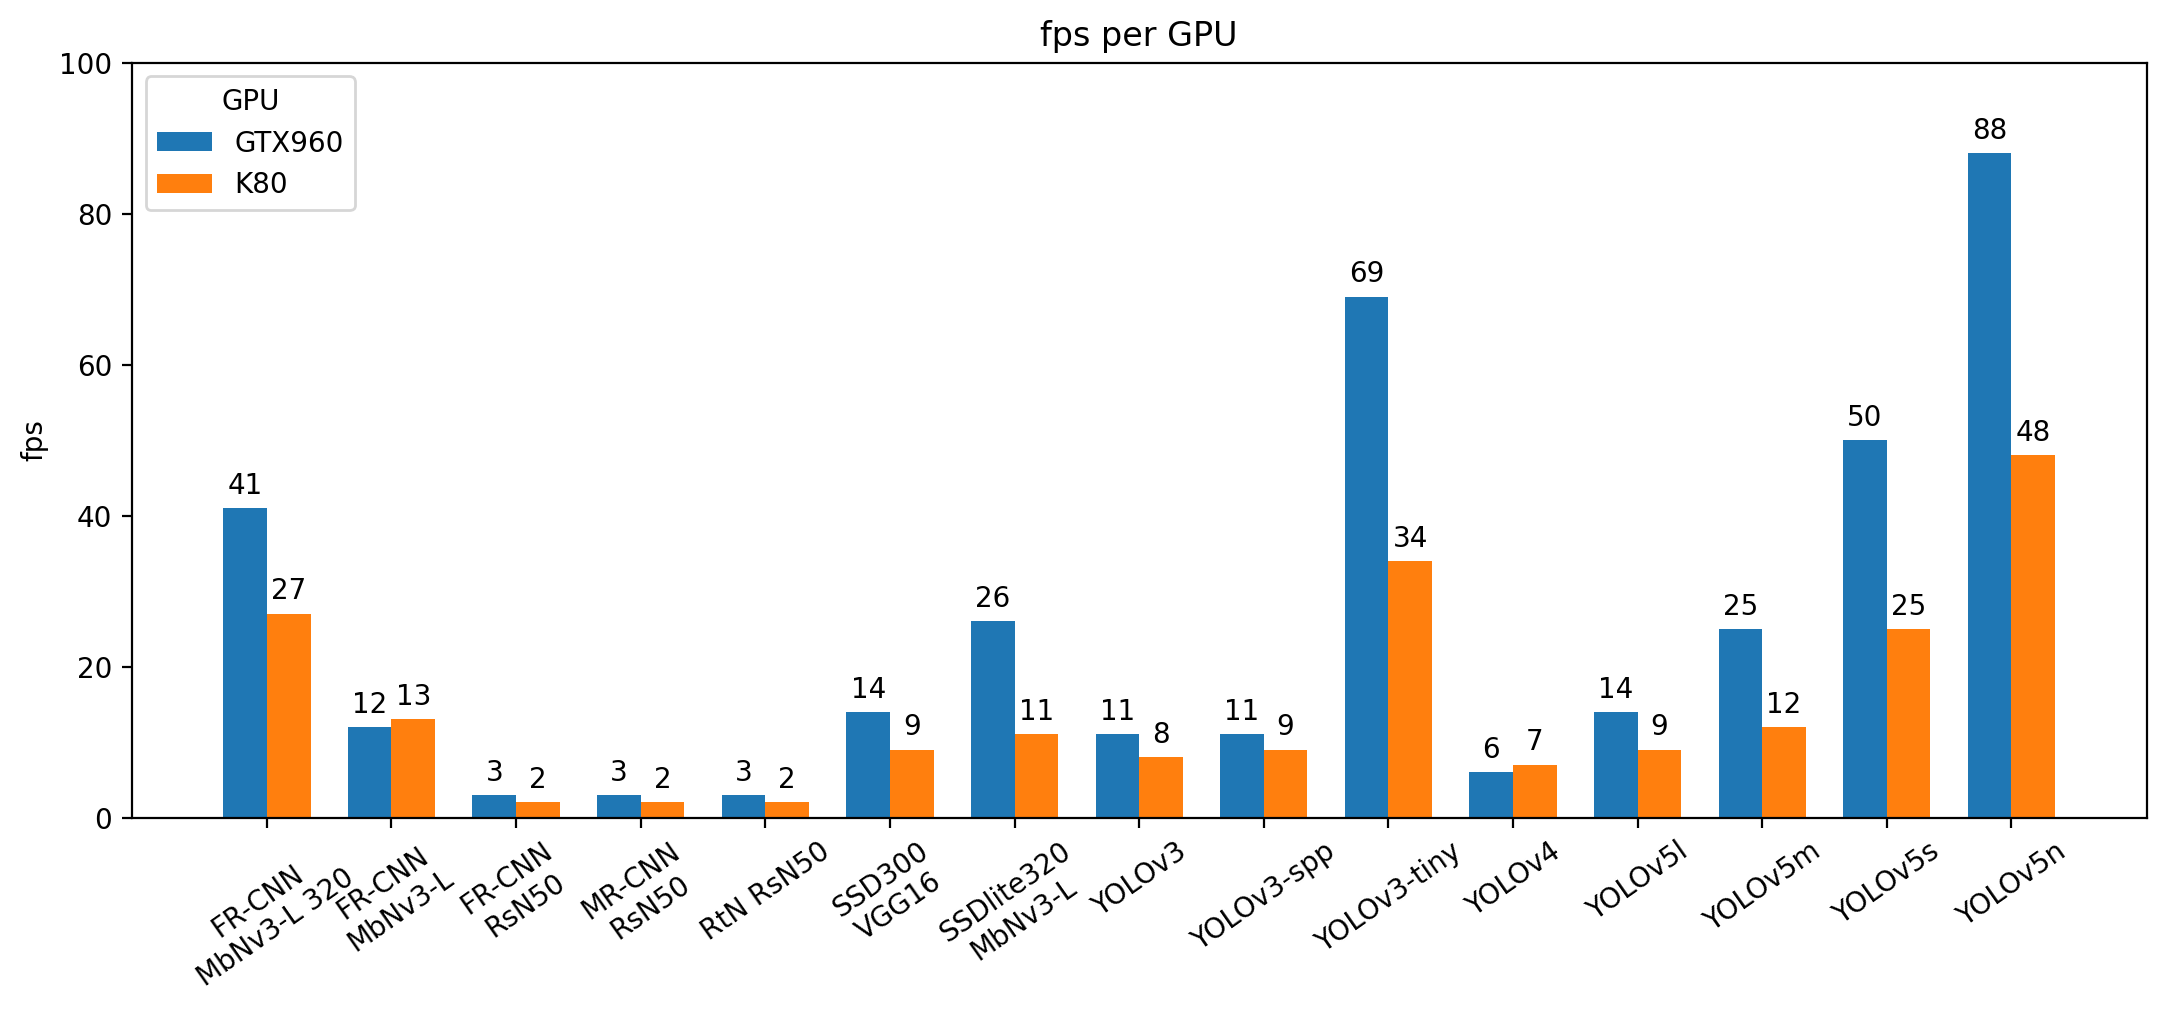

In [35]:
groups_per_gpu = results.groupby(by=['model','model_img_size','gpu'])

fps_per_gpu = groups_per_gpu.first().iloc[:,[2]].reset_index()
# Put YOLOv5n last in order
fps_per_gpu_yolov5n = fps_per_gpu[fps_per_gpu['model']=='YOLOv5n']
fps_per_gpu = fps_per_gpu[fps_per_gpu['model']!='YOLOv5n']
fps_per_gpu = fps_per_gpu.append(fps_per_gpu_yolov5n).reset_index().drop(columns=['index'])

fps_gtx960 = fps_per_gpu[fps_per_gpu['gpu']=='gtx960']['fps'].values
fps_k80 = fps_per_gpu[fps_per_gpu['gpu']=='k80']['fps'].values

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(13,5)

plt.ylim(0,100)

gtx960_bar = ax.bar(x - width/2, [int(val) for val in fps_gtx960], width, label='GTX960')
k80_bar = ax.bar(x + width/2, [int(val) for val in fps_k80], width, label='K80')

ax.set_ylabel('fps')
ax.set_title('fps per GPU')
ax.set_xticks(x)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])
plt.xticks(rotation=35)
ax.legend(title='GPU')

ax.bar_label(gtx960_bar, padding=3)
ax.bar_label(k80_bar, padding=3)

plt.show()

### Plot  mAP / fps or mAR / fps (change parameters)

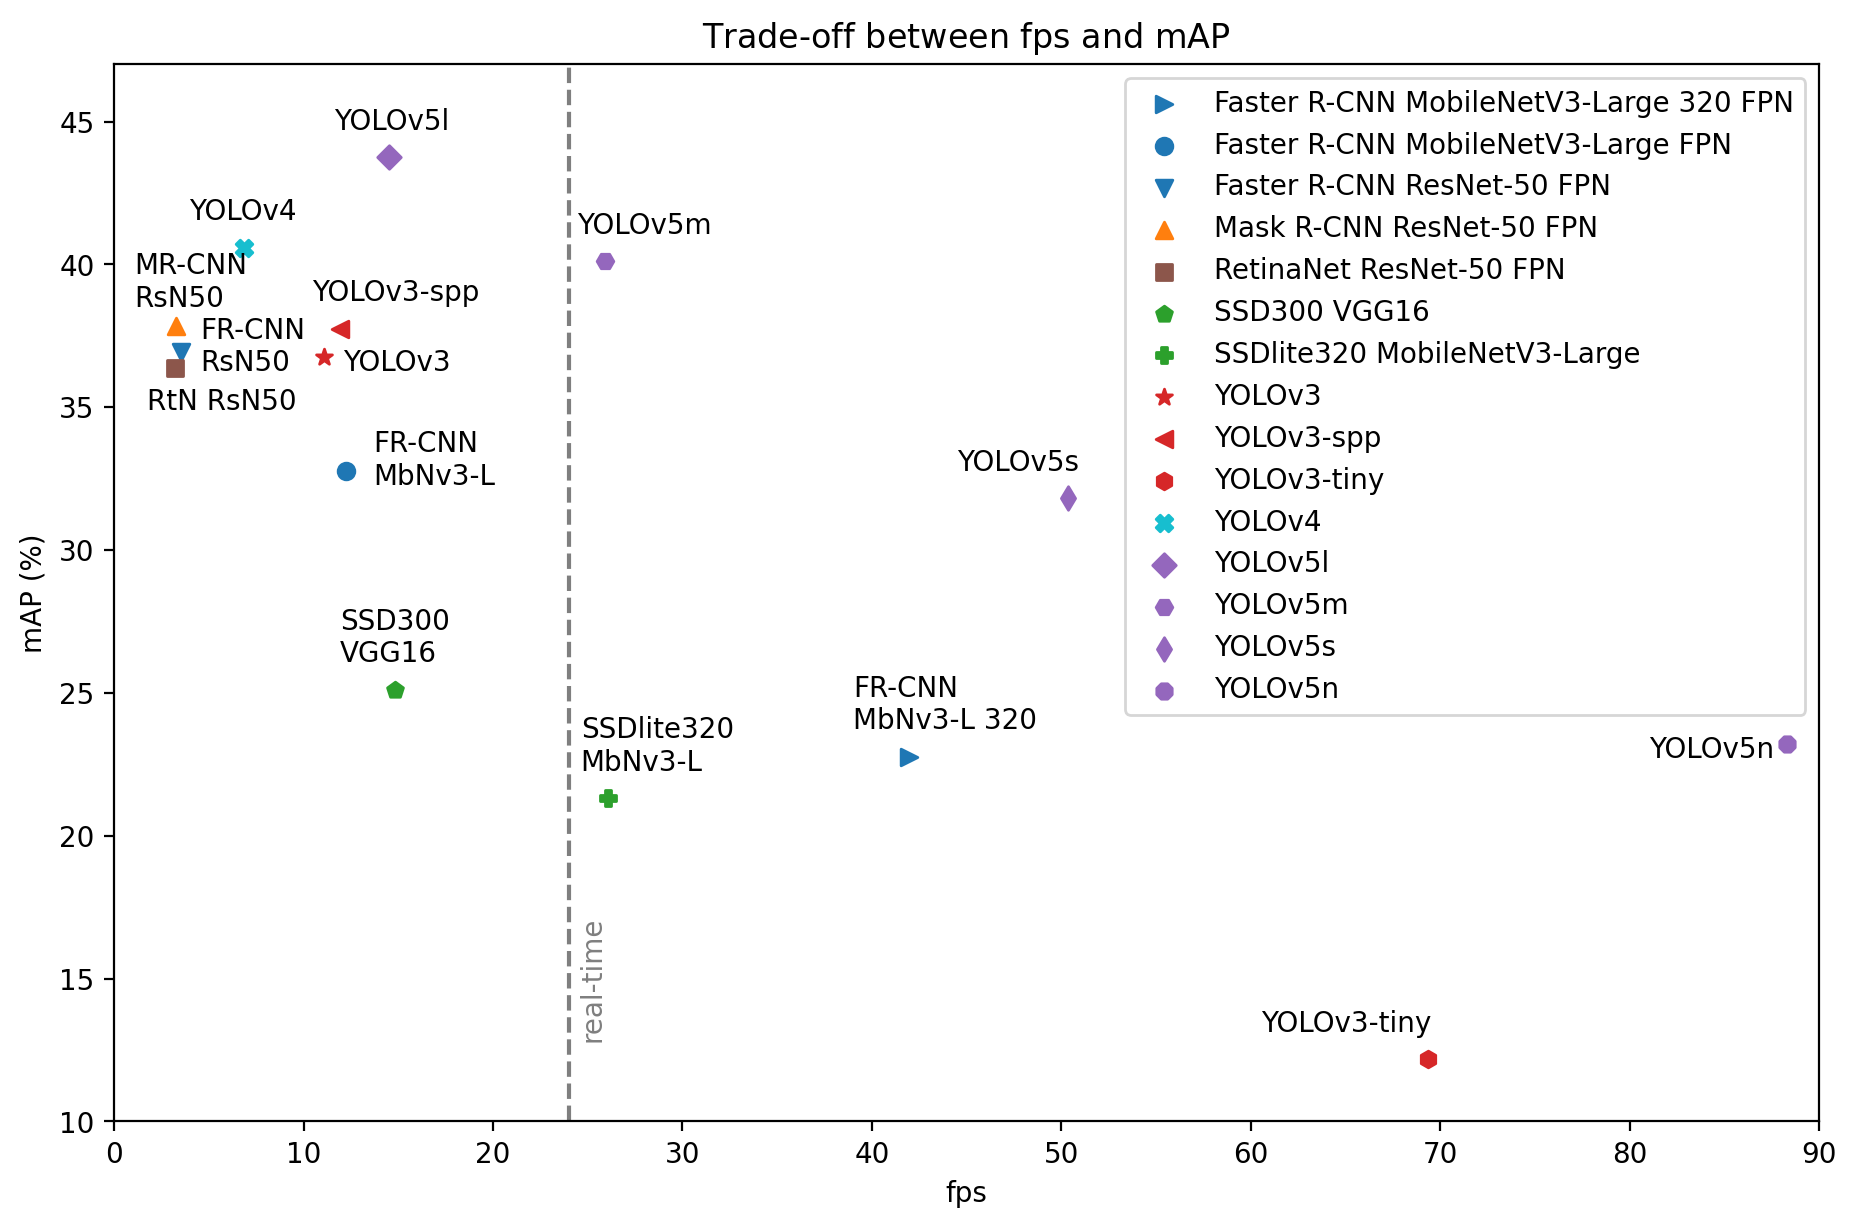

In [20]:
# Parameters
metric_name = 'avg_precision' # avg_precision or avg_recall
iou = '0.50:0.95'
area = 'all'
max_dets = 100

# Flags
show_iou = True if not iou == '0.50:0.95' else False  # show iou in plot title or not
show_area = True if not area == 'all' else False  # show area in plot title or not
show_max_dets = False  # show max_dets in plot title or not

# Get metric values
metric = results[
              (results['iou_type'] == 'bbox') &
              (results['metric'] == metric_name) & 
              (results['iou'] == iou) &
              (results['area'] == area) &
              (results['max_dets'] == max_dets)
              ]['score'].values

# Start plotting
if dataset_name == 'COCO17':
  plt.figure(figsize=(11,7))
elif dataset_name == 'PWMFD':
  plt.figure(figsize=(6,6))

metric_superscript = f'{area},max={max_dets}' if show_area & show_max_dets else area if show_area else f'max={max_dets}' if show_max_dets else ''  # metric superscript for the plot's title
metric_name_short = 'mAP' if metric_name == 'avg_precision' else 'mAR' if metric_name == 'avg_recall' else ''  # metric name for the plot's title
iou_script = f'@[{iou.replace("0.",".")}]' if show_iou else ''  # iou script for plot's title
plt.title('Trade-off between fps and ' + metric_name_short + '$^{' + metric_superscript + '}$' + iou_script )

plt.ylabel(metric_name_short + ' (%)')
plt.xlabel('fps')

if dataset_name == 'COCO17':
  if metric_name == 'avg_precision':
    xlim = (0,90)
    ylim = (10,47)
  elif metric_name == 'avg_recall':
    xlim = (0,90)
    ylim = (10,60)
if dataset_name == 'PWMFD':
  xlim = (0,90)
  ylim = (10,45)
  if subfolder == 'model':
    xlim = (0,90)
    ylim = (30,45)
  elif subfolder == 'img_size':
    xlim = (40,80)
    ylim = (30,42)

plt.xlim(xlim)
plt.ylim(ylim)

for i in range(0,len(models)):

  # Point annotation distance tuning
  if dataset_name == 'COCO17':

    if metric_name == 'avg_precision':

      xytext = (-20,10)
      if models[i] == 'SSDlite320 MobileNetV3-Large':
        xytext = (-10,10)
      if models[i] == 'Faster R-CNN ResNet-50 FPN':
        xytext = (7,-7)
      if models[i] == 'Mask R-CNN ResNet-50 FPN':
        xytext = (-15,7)
      if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
        xytext = (10,-5)
      if models[i] == 'YOLOv3':
        xytext = (7,-5)
      if models[i] == 'YOLOv3-spp':
        xytext = (-10,10)
      if models[i] == 'YOLOv5m':
        xytext = (-10,10)
      if models[i] == 'YOLOv5n':
        xytext = (-50,-5)
      if models[i] == 'YOLOv5s':
        xytext = (-40,10)
      if models[i] == 'YOLOv3-tiny':
        xytext = (-60,10)
      if models[i] == 'RetinaNet ResNet-50 FPN':
        xytext = (-10,-15)

    if metric_name == 'avg_recall':
      xytext = (-20,10)
      if models[i] == 'SSDlite320 MobileNetV3-Large':
        xytext = (-10,10) 
      if models[i] == 'Faster R-CNN ResNet-50 FPN':
        xytext = (10,-15)
      if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
        xytext = (10,-15)
      if models[i] == 'YOLOv3':
        xytext = (-5,-20) 
      if models[i] == 'YOLOv4':
        xytext = (-30,10)
      if models[i] == 'YOLOv5m':
        xytext = (-10,10)
      if models[i] == 'YOLOv5n':
        xytext = (-35,10)
      if models[i] == 'YOLOv3-tiny':
        xytext = (-60,10)
      if models[i] == 'RetinaNet ResNet-50 FPN':
        xytext = (-20,10)
      if models[i] == 'Mask R-CNN ResNet-50 FPN':
        xytext = (10,0)
  elif dataset_name == 'PWMFD':
    xytext = (-20,10)

  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (fps[i], metric[i]*100), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(fps[i],metric[i]*100,marker=markers[i],color=colors[i])

# Plot vertical line for real-time fps
if dataset_name == 'COCO17':
  plt.vlines(x=24, ymin=ylim[0], ymax=ylim[1], colors='tab:grey', linestyles='dashed')
  plt.text(24.5, 15, "real-time", rotation=90, verticalalignment='center', color='tab:grey')


plt.legend(models, scatterpoints=1)

plt.show()

### Plot  mAP or mAR (small,medium,large) per model (change parameters)

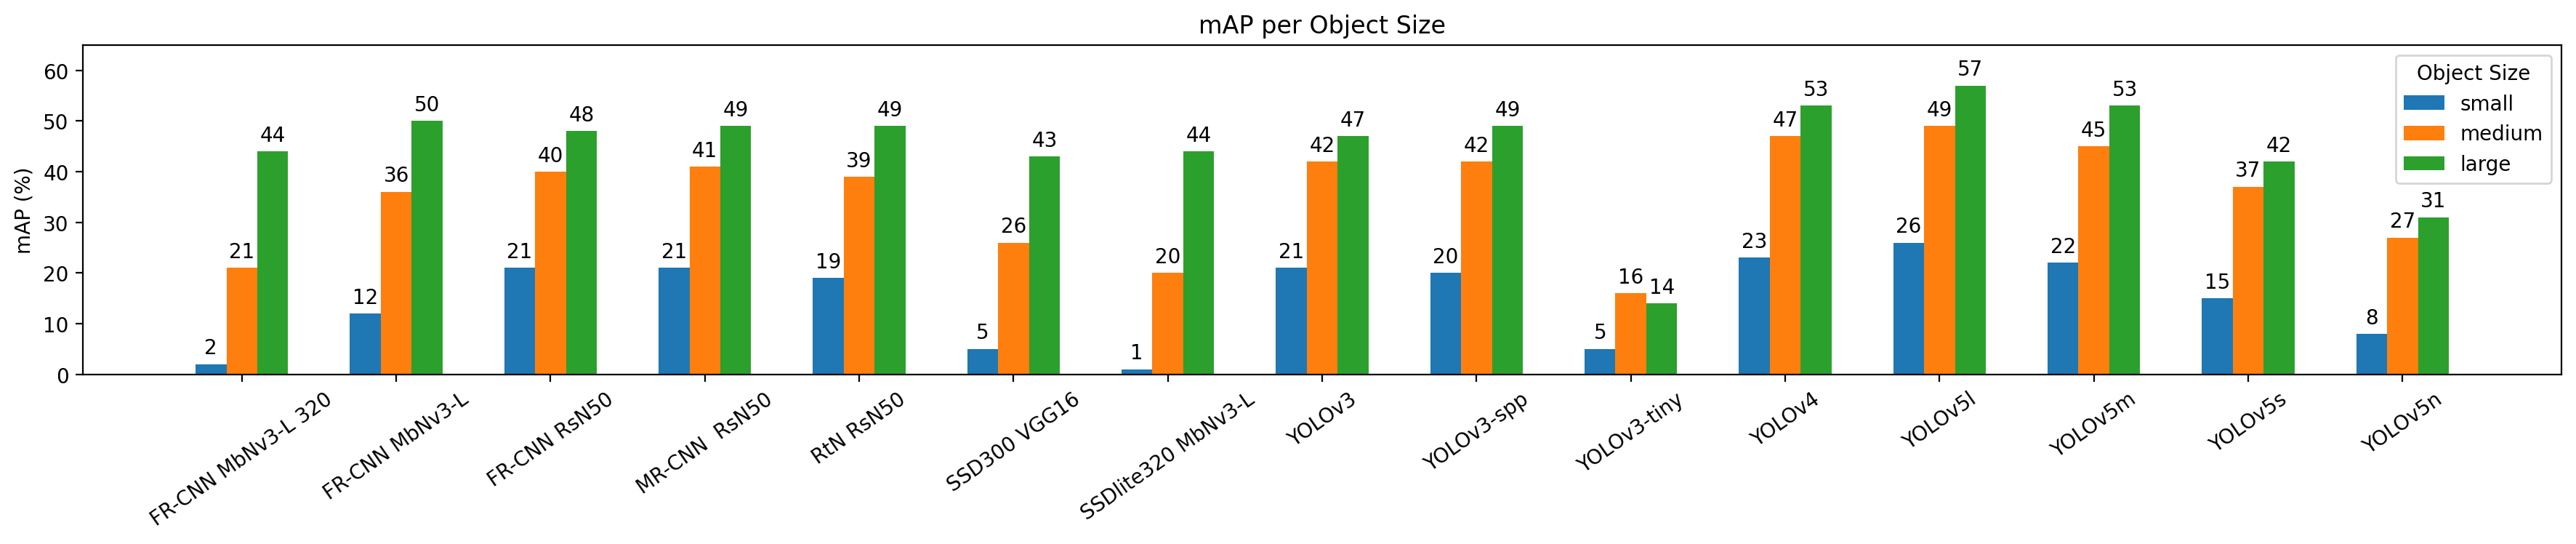

In [10]:
# Parameters
metric_name = 'avg_precision'  # avg_precision or avg_recall

# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

# Plot bar chart

fig, ax = plt.subplots()
if dataset_name == 'PWMFD':
  fig.set_size_inches(20,6)
  if subfolder == 'transfer_learning':
    fig.set_size_inches(10,6)
  if subfolder == 'optimizer':
    fig.set_size_inches(7,6)
  if subfolder == 'augmentations':
    fig.set_size_inches(10,6)
  if subfolder == 'te_block':
    fig.set_size_inches(10,6)
  if subfolder == 'se_block':
    fig.set_size_inches(10,2)
    
if dataset_name == 'COCO17':
  fig.set_size_inches(22,3)


if metric_name == 'avg_precision':
  metric_name_short = 'mAP'
  metric_small = mAP_small 
  metric_medium = mAP_medium
  metric_large = mAP_large
  if subfolder == None:
    plt.ylim(0,65)
  elif subfolder == 'se_block':
    plt.ylim(0,90)
  elif subfolder == 'te_block':
    plt.ylim(0,83)

elif metric_name == 'avg_recall':
  metric_name_short = 'mAR'
  metric_small = mAR_small 
  metric_medium = mAR_medium
  metric_large = mAR_large
  plt.ylim(0,75)

# Change plot order
temp_models_short = models_short
temp_metric_small = metric_small
temp_metric_medium = metric_medium
temp_metric_large = metric_large
if dataset_name == 'PWMFD':
  if subfolder == 'transfer_learning':
    temp_models_short = [models_short[i] for i in [2,3,0,1]]
    temp_models_short = [metric_small[i] for i in [2,3,0,1]]
    temp_models_short = [metric_medium[i] for i in [2,3,0,1]]
    temp_models_short = [metric_large[i] for i in [2,3,0,1]]
  elif subfolder == 'augmentations':
    temp_models_short = [models_short[i] for i in [2,0,1]]
    temp_metric_small = [metric_small[i] for i in [2,0,1]]
    temp_metric_medium = [metric_medium[i] for i in [2,0,1]]
    temp_metric_large = [metric_large[i] for i in [2,0,1]]
  elif subfolder == 'se_block':
    temp_models_short = [models_short[i] for i in [0,2,4,1,3]]
    temp_metric_small = [metric_small[i] for i in [0,2,4,1,3]]
    temp_metric_medium = [metric_medium[i] for i in [0,2,4,1,3]]
    temp_metric_large = [metric_large[i] for i in [0,2,4,1,3]]

small_bar = ax.bar(x - width, to_percent(temp_metric_small), width, label='small')
medium_bar = ax.bar(x, to_percent(temp_metric_medium), width, label='medium')
large_bar = ax.bar(x + width, to_percent(temp_metric_large), width, label='large')

ax.set_title(f'{metric_name_short} per Object Size')

ax.set_ylabel(f'{metric_name_short} (%)')
ax.set_xticks(x)
if dataset_name=='COCO17':
  plt.xticks(rotation=35)
ax.set_xticklabels(temp_models_short)
ax.legend(title='Object Size') # ncol=3 for horizontal legend

ax.bar_label(small_bar, padding=3)
ax.bar_label(medium_bar, padding=3)
ax.bar_label(large_bar, padding=3)


plt.show()

### Plot  mAP (IoU = [0.50,0.75.0,50:0,0.95]) per model

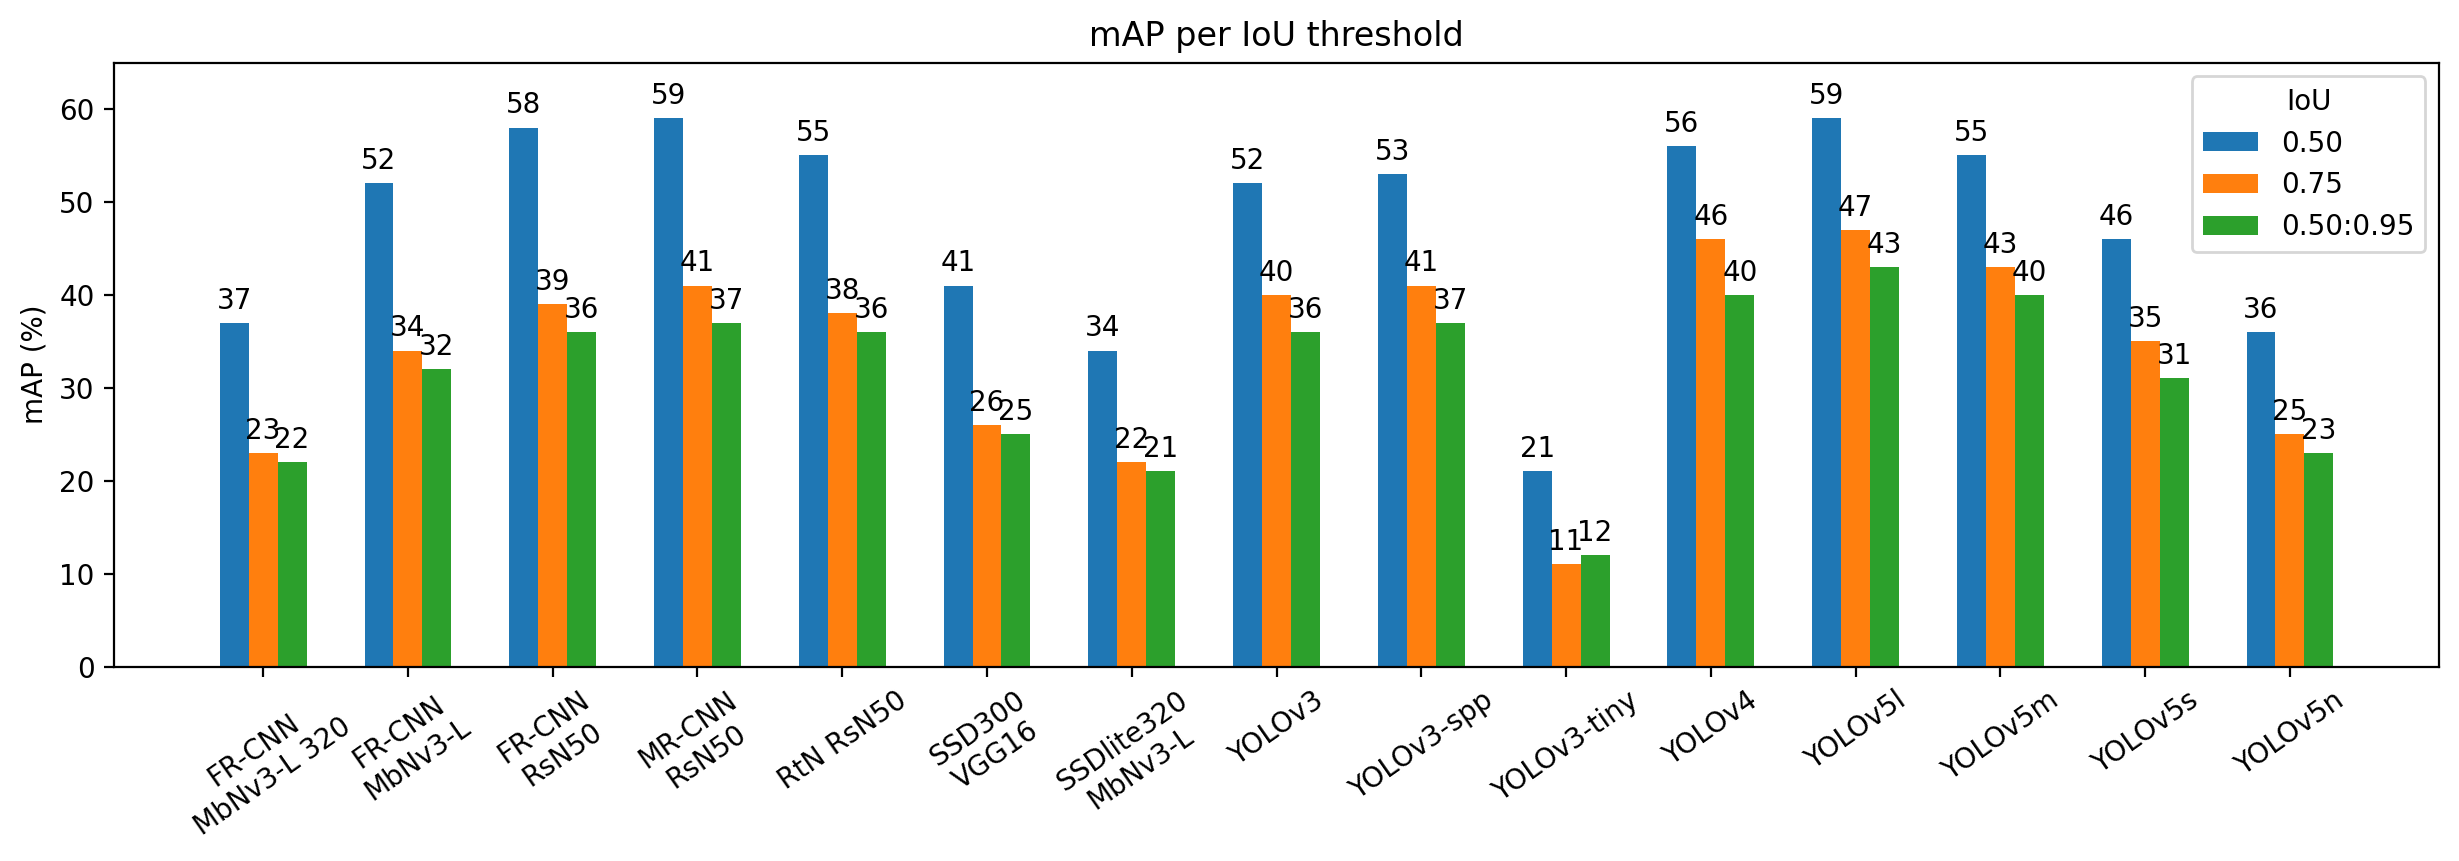

In [11]:
# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars


# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(15,4)

iou50_bar = ax.bar(x - width, to_percent(mAP_50), width, label='0.50')
iou75_bar = ax.bar(x, to_percent(mAP_75), width, label='0.75')
iou5095_bar = ax.bar(x + width, to_percent(mAP), width, label='0.50:0.95')


ax.set_ylabel('mAP (%)')
plt.ylim(0,65)

ax.set_title('mAP per IoU threshold')
ax.set_xticks(x)
plt.xticks(rotation=35)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])

ax.legend(title='IoU')

ax.bar_label(iou50_bar, padding=3)
ax.bar_label(iou75_bar, padding=3)
ax.bar_label(iou5095_bar, padding=3)


plt.show()

### Plot  mAR (max det = [1,10,100]) per model

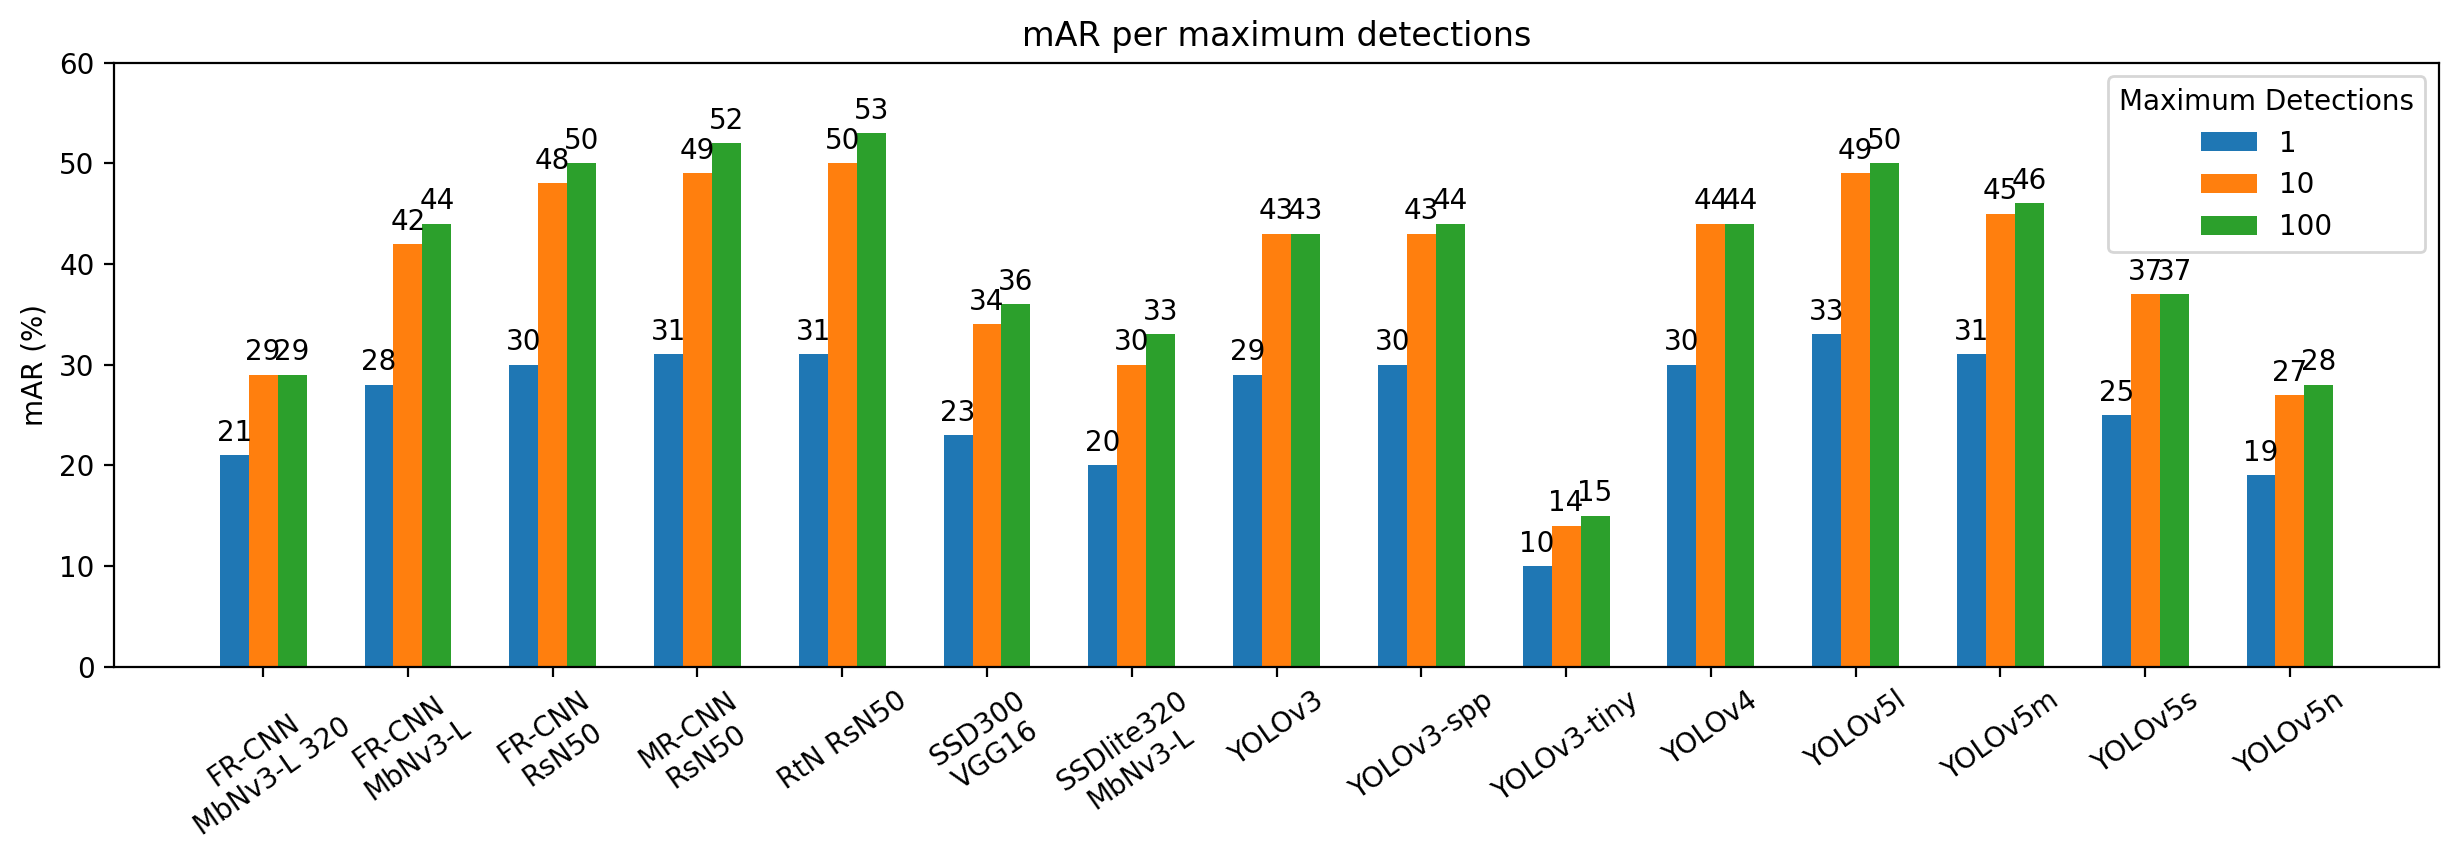

In [12]:
# Bar chart settings
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars


# Plot bar chart

fig, ax = plt.subplots()
fig.set_size_inches(15,4)

max1_bar = ax.bar(x - width, to_percent(mAR_1), width, label='1')
max10_bar = ax.bar(x, to_percent(mAR_10), width, label='10')
max100_bar = ax.bar(x + width, to_percent(mAR), width, label='100')

ax.set_ylabel('mAR (%)')
plt.ylim(0,60)

ax.set_title('mAR per maximum detections')
ax.set_xticks(x)
ax.set_xticklabels([tw.fill(model_name, width=11) for model_name in models_short])
plt.xticks(rotation=35)

ax.legend(title='Maximum Detections')

ax.bar_label(max1_bar, padding=3)
ax.bar_label(max10_bar, padding=3)
ax.bar_label(max100_bar, padding=3)


plt.show()

### Plot model mAP / GFLOPs

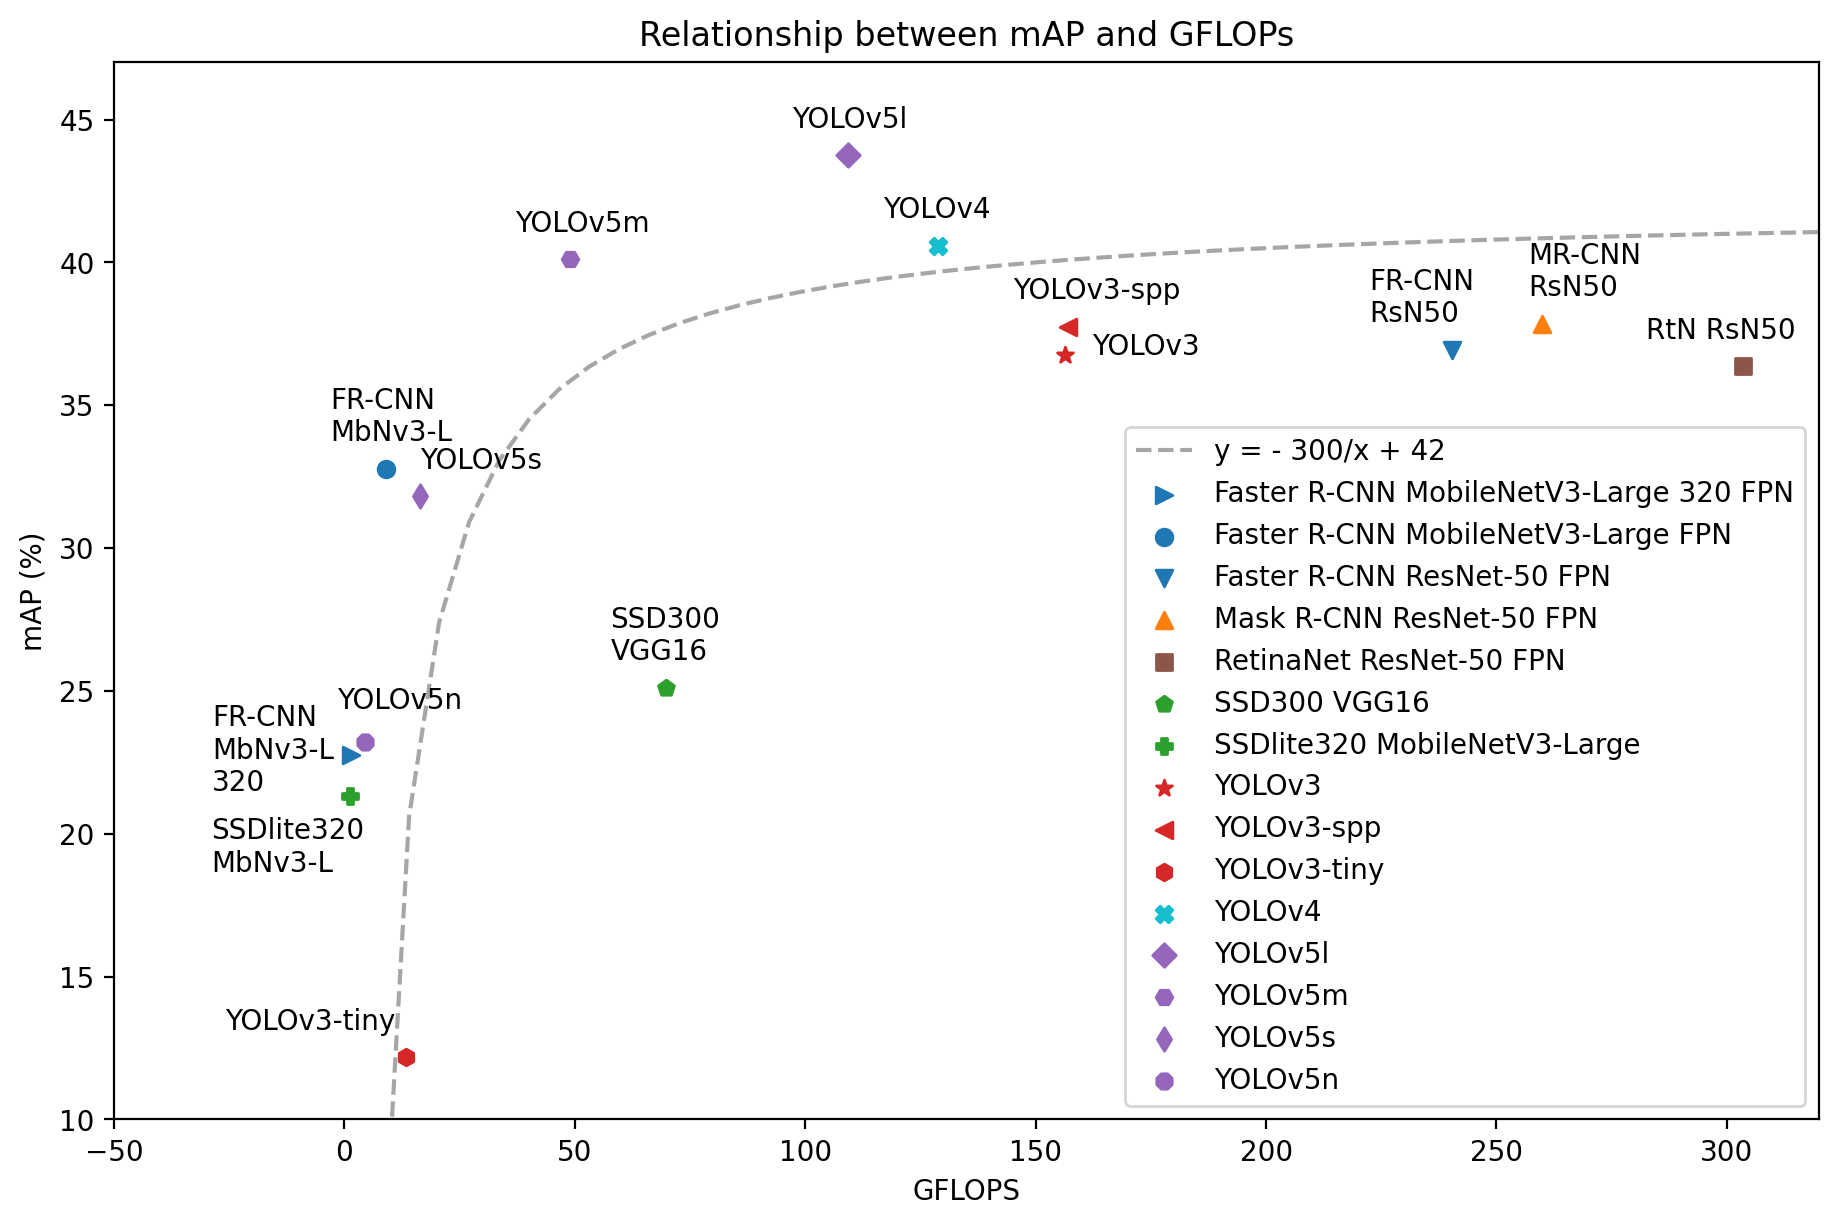

In [19]:
# Start plotting
plt.figure(figsize=(11,7))

plt.title('Relationship between mAP and GFLOPs')
plt.xlabel('GFLOPS')
plt.ylabel('mAP (%)')

xlim = (-50,320)
ylim = (10,47)
plt.xlim(xlim)
plt.ylim(ylim)

# Plot hyperbole
x = np.linspace(1,320)
y = - 300 * 1/x + 42
plt.plot(x,y,'--',color='#a6a6a6',zorder=0)

# Plot points
for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-30,10) 
  if models[i] == 'Faster R-CNN MobileNetV3-Large 320 FPN':
    xytext = (-50,-13)
  if models[i] == 'Mask R-CNN ResNet-50 FPN':
    xytext = (-5,10)
  if models[i] == 'YOLOv3':
    xytext = (10,0) 
  if models[i] == 'YOLOv3-tiny':
    xytext = (-65,10) 
  if models[i] == 'YOLOv5s':
    xytext = (0,10) 
  if models[i] == 'YOLOv5n':
    xytext = (-10,12) 
  if models[i] == 'SSDlite320 MobileNetV3-Large':
    xytext = (-50,-27)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-35,10)
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=10) if 'tiny' not in models_short[i] else models_short[i], (model_gflops[i], mAP[i]*100), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(model_gflops[i],mAP[i]*100, marker=markers[i], color=colors[i])

plt.legend(np.insert(models,0,'y = - 300/x + 42'), scatterpoints=1)

plt.show()

### Plot model fps / GFLOPs

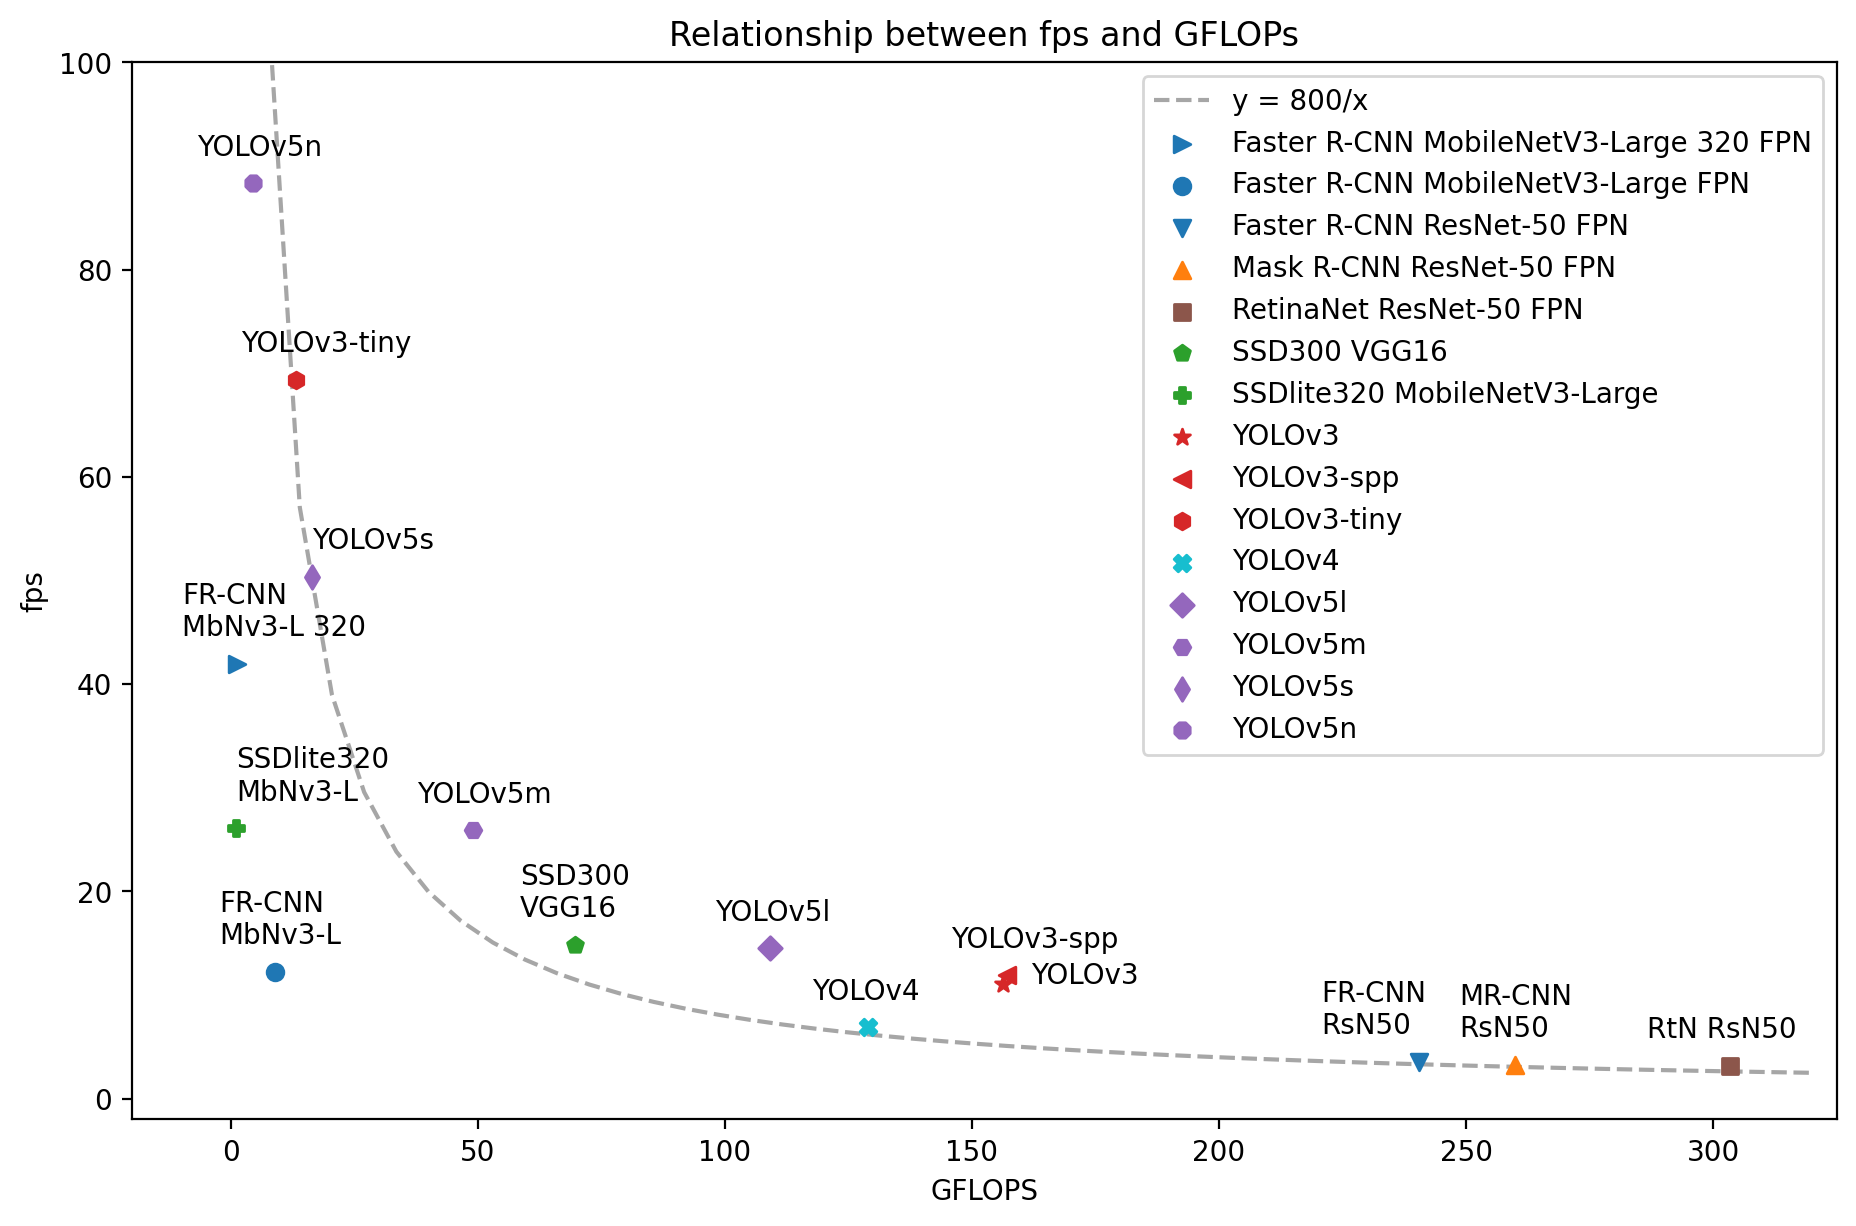

In [23]:
# Start plotting
plt.figure(figsize=(11,7))

plt.title('Relationship between fps and GFLOPs')
plt.xlabel('GFLOPS')
plt.ylabel('fps')

xlim = (-20,325)
ylim = (-2,100)
plt.xlim(xlim)
plt.ylim(ylim)

# Plot hyperbole
x = np.linspace(1,320)
y = 800 * 1/x
plt.plot(x,y,'--',color='#a6a6a6',zorder=0)

# Plot points
for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-35,10) 
  if models[i] == 'YOLOv3':
    xytext = (10,0) 
  if models[i] == 'YOLOv5s':
    xytext = (0,10) 
  if models[i] == 'SSDlite320 MobileNetV3-Large':
    xytext = (0,10)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-30,10)
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=11), (model_gflops[i], fps[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(model_gflops[i],fps[i], marker=markers[i], color=colors[i])

plt.legend(np.insert(models,0,'y = 800/x'), scatterpoints=1)

plt.show()

### Plot GFLOPs

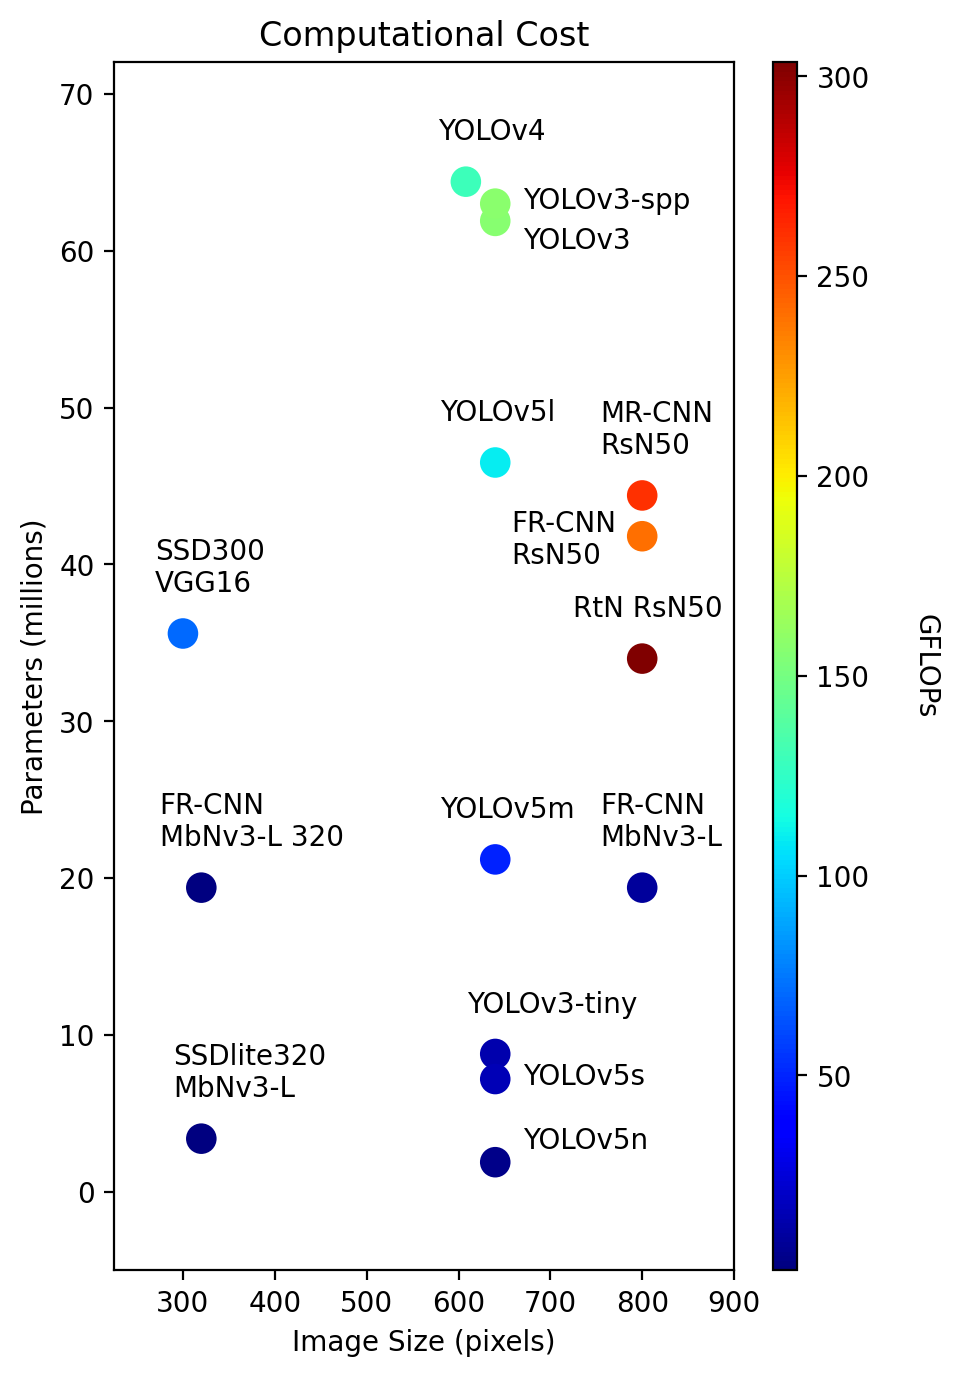

In [24]:
plt.figure(figsize=(5,8))

plt.title('Computational Cost')

plt.ylabel('Parameters (millions)')
plt.xlabel('Image Size (pixels)')

xlim = (225,900)
ylim = (-5,72)

plt.xlim(xlim)
plt.ylim(ylim)

plt.scatter(model_img_size,model_params,c=model_gflops,s=100, cmap='jet')

for i in range(0,len(models)):
  xytext = (-10,15)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-47,-10)
  if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
    xytext = (-15,15)
  if models[i] == 'Faster R-CNN MobileNetV3-Large 320 FPN':
    xytext = (-15,15)
  if models[i] == 'YOLOv3':
    xytext = (10,-10) 
  if models[i] == 'YOLOv3-spp':
    xytext = (10,-2) 
  if models[i] == 'YOLOv5l':
    xytext = (-20,15)
  if models[i] == 'YOLOv5m':
    xytext = (-20,15)
  if models[i] == 'YOLOv5s':
    xytext = (10,-2)
  if models[i] == 'YOLOv5n':
    xytext = (10,5)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-25,15)
  if models[i] == 'Mask R-CNN ResNet-50 FPN':
    xytext = (-15,15)
  plt.annotate(tw.fill(models_short[i], width=11), (model_img_size[i], model_params[i]), xytext=xytext, textcoords='offset points')

cbar = plt.colorbar(aspect=50)
cbar.set_label('GFLOPs', rotation=270, labelpad=25)


### Plot Memory usage

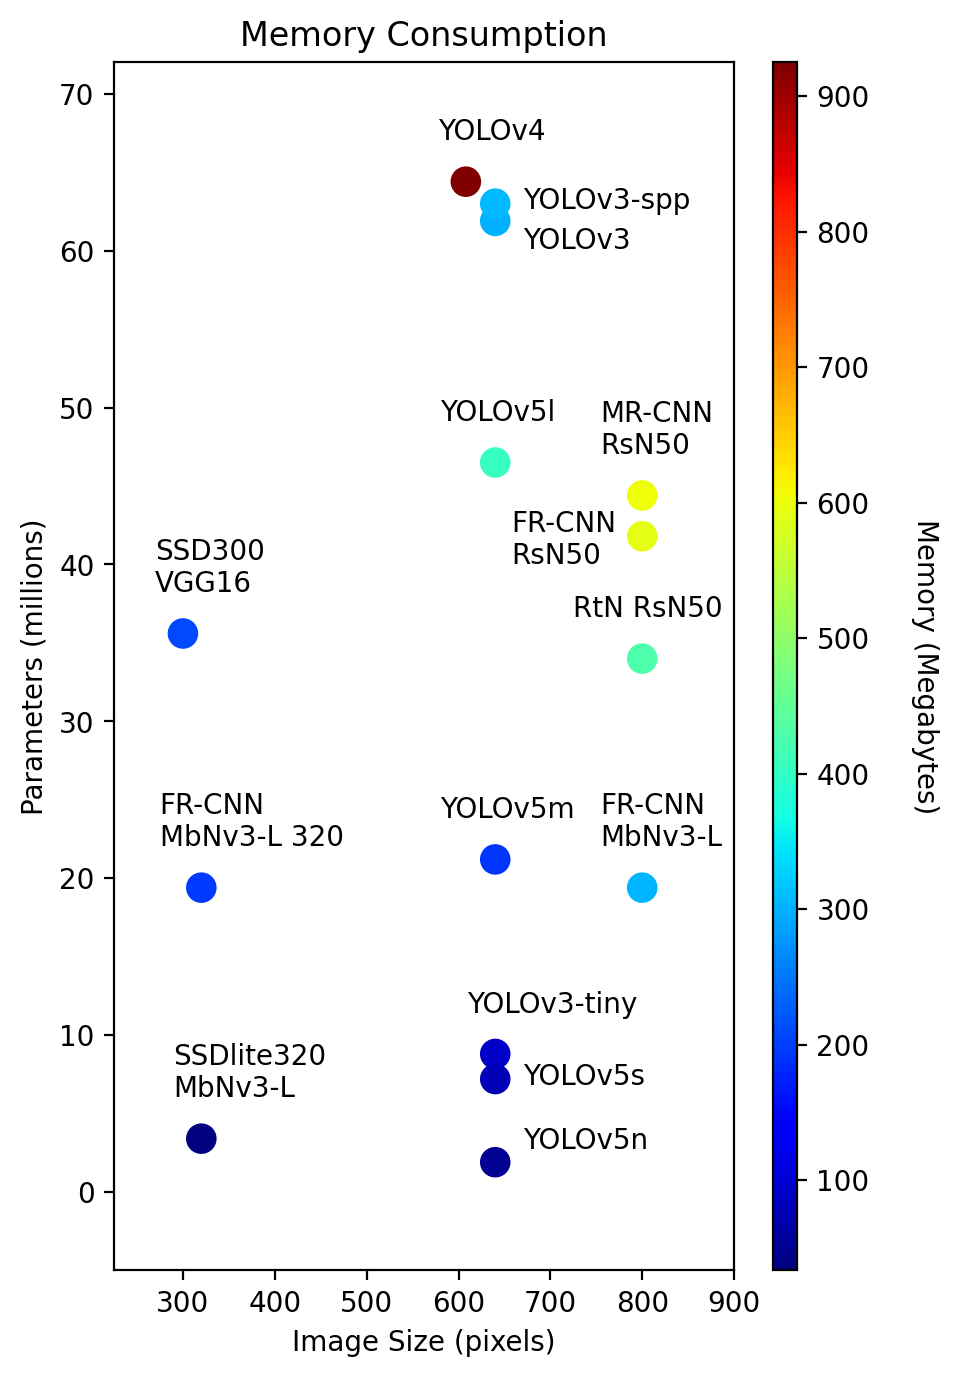

In [25]:
plt.figure(figsize=(5,8))

plt.title('Memory Consumption' )

plt.ylabel('Parameters (millions)')
plt.xlabel('Image Size (pixels)')

xlim = (225,900)
ylim = (-5,72)

plt.xlim(xlim)
plt.ylim(ylim)

xytext = (10,5)

plt.scatter(model_img_size,model_params,c=max_mem,s=100, cmap='jet')

for i in range(0,len(models)):
  xytext = (-10,15)
  if models[i] == 'Faster R-CNN ResNet-50 FPN':
    xytext = (-47,-10)
  if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
    xytext = (-15,15)
  if models[i] == 'Faster R-CNN MobileNetV3-Large 320 FPN':
    xytext = (-15,15)
  if models[i] == 'YOLOv3':
    xytext = (10,-10) 
  if models[i] == 'YOLOv3-spp':
    xytext = (10,-2) 
  if models[i] == 'YOLOv5l':
    xytext = (-20,15)
  if models[i] == 'YOLOv5m':
    xytext = (-20,15)
  if models[i] == 'YOLOv5s':
    xytext = (10,-2)
  if models[i] == 'YOLOv5n':
    xytext = (10,5)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-25,15)
  if models[i] == 'Mask R-CNN ResNet-50 FPN':
    xytext = (-15,15)
  plt.annotate(tw.fill(models_short[i], width=11), (model_img_size[i], model_params[i]), xytext=xytext, textcoords='offset points')

cbar = plt.colorbar(aspect=50)
cbar.set_label('Memory (Megabytes)', rotation=270, labelpad=25)


### Plot Storage / Parameters

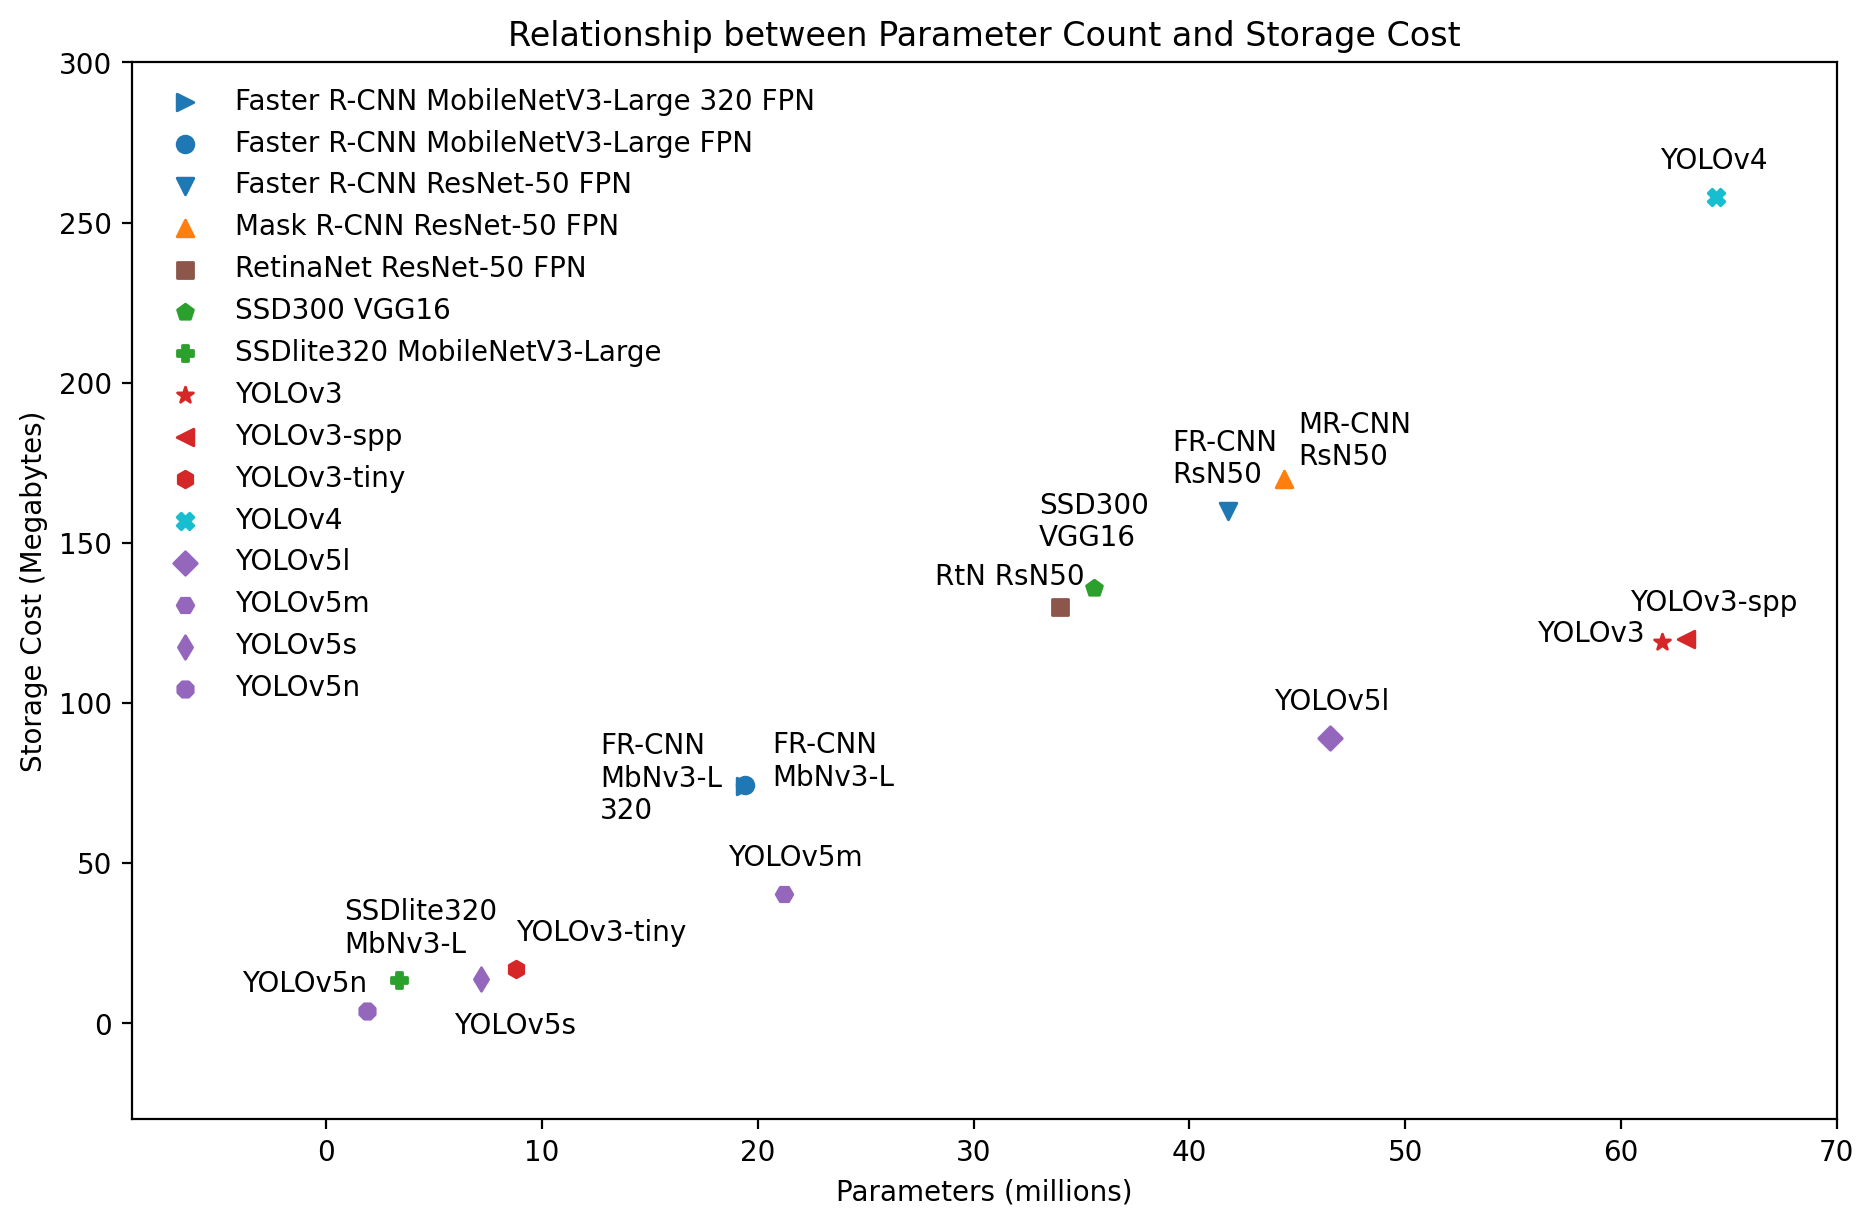

In [26]:
model_storage = [74.2,74.3,160,170,130,136,13.4,119,120,17,258,89.2,40.5,14,3.8]


# Start plotting
plt.figure(figsize=(11,7))

plt.title('Relationship between Parameter Count and Storage Cost')

plt.xlabel('Parameters (millions)')
plt.ylabel('Storage Cost (Megabytes)')

xlim = (-9,70)
ylim = (-30,300)
plt.xlim(xlim)
plt.ylim(ylim)

# Plot hyperbole
# x = np.linspace(1,320)
# y = - 3.5 * 1/x + 0.42
# plt.plot(x,y,'--',color='#a6a6a6',zorder=0)

# Plot points
for i in range(len(models)):
  # Point annotation distance tuning
  xytext = (-20,10)
  # if models[i] == 'Faster R-CNN ResNet-50 FPN':
  #   xytext = (-35,10) 
  if models[i] == 'Faster R-CNN MobileNetV3-Large FPN':
    xytext = (10,0)
  if models[i] == 'Faster R-CNN MobileNetV3-Large 320 FPN':
    xytext = (-52,-12)
  if models[i] == 'Mask R-CNN ResNet-50 FPN':
    xytext = (5,5)
  if models[i] == 'YOLOv3':
    xytext = (-45,0) 
  if models[i] == 'YOLOv3-tiny':
    xytext = (0,10) 
  if models[i] == 'YOLOv5s':
    xytext = (-10,-20) 
  if models[i] == 'YOLOv5n':
    xytext = (-45,7) 
  if models[i] == 'SSD300 VGG16':
    xytext = (-20,15)
  # if models[i] == 'SSDlite320 MobileNetV3-Large':
  #   xytext = (-50,-27)
  if models[i] == 'RetinaNet ResNet-50 FPN':
    xytext = (-45,8)
  # Point annotations
  plt.annotate(tw.fill(models_short[i], width=10) if 'tiny' not in models_short[i] else models_short[i], (model_params[i], model_storage[i]), xytext=xytext, textcoords='offset points')
  # Scatter plot
  plt.scatter(model_params[i],model_storage[i], marker=markers[i], color=colors[i])

plt.legend(models, scatterpoints=1, frameon=False) 

plt.show()